In [1]:
import numpy as np
import matplotlib.pyplot as plt
import scipy.interpolate
import pandas as pd
from mpl_toolkits.mplot3d import Axes3D
from scipy import stats
import time
%matplotlib inline

In [2]:
# physical parameters
q = -1.60217662e-19 # coulombs
m = 9.10938356e-31 #kg (electron)
#m = 6.6359437706294e-26 #(calcium)
kB = 1.38064852e-23 # J/K
f = 1.5e9 # Electrode frequency, in Hertz

### Note that the data is only a quarter of the plane. In order to get the E field data of the whole plane, i need to mirror the data to the other three quadrants to get the full information.

In [3]:
# loading E field (vector)
data = np.loadtxt("etrap_65V_1p5GHz_realsmoothExEy_500nm_25passes_quarter.fld", skiprows = 2)

In [4]:
# manipulating E field data
df = pd.DataFrame(data, columns=['x', 'y', 'z', 'Ex', 'Ey', 'Ez'])
x_max, x_min = df.x.max(), df.x.min()
y_max, y_min = df.y.max(), df.y.min()
# print(x_max, x_min, y_max, y_min)
# print(df.y.nunique())
Nx, Ny = df.x.nunique() - 1, df.y.nunique() - 1 # numbers of intervals that divide each dimension
dx, dy = (x_max-x_min)/Nx, (y_max-y_min)/Ny # interval size
print("x_max = ", x_max*1.0e3, "mm")
print("y_max = ", y_max*1.0e3, "mm")
print("x_min = ", x_min*1.0e3, "mm")
print("y_min = ", y_min*1.0e3, "mm")
print("spatial resolution x: ", dx*1.0e6, "um")
print("spatial resolution y: ", dy*1.0e6, "um")

x_max =  2.0000000000000004 mm
y_max =  2.0000000000000004 mm
x_min =  0.0 mm
y_min =  0.0 mm
spatial resolution x:  0.5000000000000001 um
spatial resolution y:  0.5000000000000001 um


x     0.000000
y     0.000000
z     0.000000
Ex    2.017668
Ey    0.351039
Ez    0.000000
Name: 0, dtype: float64


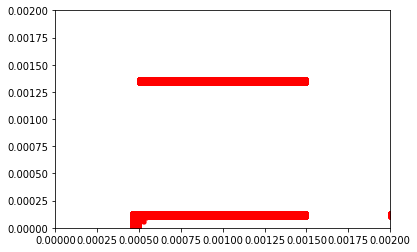

In [5]:
electrode = df.loc[(np.abs(df["Ex"]) < 1.0e-8) & (np.abs(df["Ey"]) < 1.0e-8)]
x_electrode = electrode.iloc[:, 0].values
y_electrode = electrode.iloc[:, 1].values
plt.plot(x_electrode, y_electrode, "r.")
plt.xlim((x_min, x_max))
plt.ylim((y_min, y_max))
print(df.iloc[0, :])

In [10]:
def get_row_index(x, y):
    # given spatial coordinates x and y, 
    # output the index of the row corresponding to the coordinates
    # this only works for the first quadrant
    if x > x_max:
        x = x_max
    if x < x_min:
        x = x_min
    if y > y_max:
        y = y_max
    if y < y_min:
        y = y_min
    i = int((x - x_min) / dx)
    j = int((y - y_min) / dy)
    return i * (Nx + 1) + j
# n = get_row_index(-0.000381, 0.000275)
# print(n)
# print(df.iloc[n, :])

def grad_Ex(x, y):
    # return the gradient of x component of electric field at position (x, y);
    # used to interpolate E field between grid points
    # note that x, y are supposed to be on grid intersections.
    # Works for all four quadrants
    x, y = abs(x), abs(y)
    n = get_row_index(x, y)
    if x == x_max:
        nx = get_row_index(x-dx, y)
        x_deriv = (df.iloc[n,3] - df.iloc[nx,3])/(dx)
    else:
        nx = get_row_index(x+dx, y)
        x_deriv = (df.iloc[nx,3] - df.iloc[n,3])/(dx)
    if y == y_max:
        ny = get_row_index(x, y-dy)
        y_deriv = (df.iloc[n,3] - df.iloc[ny,3])/(dy)
    else:
        ny = get_row_index(x, y+dy)
        y_deriv = (df.iloc[ny,3] - df.iloc[n,3])/(dy)
    return (x_deriv, y_deriv)

def grad_Ey(x, y):
    # return the gradient of x component of electric field at position (x, y);
    # used to interpolate E field between grid points
    # note that x, y are supposed to be on grid intersections
    x, y = abs(x), abs(y)
    n = get_row_index(x, y)
    if x == x_max:
        nx = get_row_index(x-dx, y)
        x_deriv = (df.iloc[n,4] - df.iloc[nx,4])/(dx)
    else:
        nx = get_row_index(x+dx, y)
        x_deriv = (df.iloc[nx,4] - df.iloc[n,4])/(dx)
    if y == y_max:
        ny = get_row_index(x, y-dy)
        y_deriv = (df.iloc[n,4] - df.iloc[ny,4])/(dy)
    else:
        ny = get_row_index(x, y+dy)
        y_deriv = (df.iloc[ny,4] - df.iloc[n,4])/(dy)
    return (x_deriv, y_deriv)


def E_field(x, y, t):
    # return the electric field at position (x, y) at time t
    x = abs(x)
    y = abs(y)
    n = get_row_index(x, y)
    x0, y0 = df.iloc[n, 0], df.iloc[n, 1]
    Ex0, Ey0 = df.iloc[n, 3], df.iloc[n, 4]
    Ex = Ex0 + grad_Ex(x0, y0)[0] * (x-x0) + grad_Ex(x0, y0)[1] * (y-y0)
    Ey = Ey0 + grad_Ey(x0, y0)[0] * (x-x0) + grad_Ey(x0, y0)[1] * (y-y0)
    return (Ex*np.cos(2*np.pi*f*t), Ey*np.cos(2*np.pi*f*t))

def acceleration(x, y, t):
    Ex, Ey= E_field(x, y, t)
    return np.array([Ex*q/m, Ey*q/m])

def within_boundary(x, y):
    x, y = abs(x), abs(y)
    # check whether the x, y, z coordinate of an electron is within
    # our area of interest.
    n = get_row_index(x, y)
    #return x<x_max and x>x_min and y<y_max and y>y_min
    return x<x_max and y<y_max and \
(abs(df.iloc[n, 3]) >= 1.0e-7 or abs(df.iloc[n, 4]) >= 1.0e-7) 

In [7]:
def rk4(y, time, dt, derivs): 
    f0 = derivs(y, time)
    fhalf_bar = derivs(y+f0*dt/2, time+dt) 
    fhalf = derivs(y+fhalf_bar*dt/2, time+dt)
    f1_bar= derivs(y+fhalf*dt, time+dt)
    y_next = y+dt/6*(f0+2*fhalf_bar+2*fhalf+f1_bar)
    return y_next

def E_field_sim(state, time):
    # this is a function that takes in a 2-element array state and a number time.
    # state[0] is current position and state[1] is current velocity.
    # it calculates the derivative of state, and returns a 2-element array,
    # with the 0th element being derivative of position and the 1th being 
    # the acceleration
    g0 = state[1]
    x, y = state[0]
    g1 = acceleration(x, y, time)
    return np.array([g0, g1])

In [8]:
def trapped(rou, phi, v, theta, dt, t_max):

    electron_pos=np.array([rou*np.cos(phi), rou*np.sin(phi)])
    electron_vel = np.array([v*np.cos(theta), v*np.sin(theta)])
    state = np.array([electron_pos, electron_vel])
    t = 0.0 # the time variable
    trapped = True
    
    # actual simulation
    while t < t_max:
        x, y = state[0]
        if not within_boundary(x, y):
            trapped = False
            break
        state = rk4(state, t, dt, E_field_sim)
        t += dt
    return trapped

def Boltzmann_sim(N_ion_samples, T, dt, t_max, FWHM):
    # Simulate ion in the trap with initial condition characterized by a 
    # Boltzmann distribution of temperature T. The simulation (using RK4) step size 
    # is dt, and the maximum time duration of the simulation is t_max. The initial position
    # of the ion is characterized by a Gaussian distribution with full-width-half max FWHM.
    # the function returns a list of length N_ion_sample. 
    # The ith element of the list is 1 iff the ith ion is successfully trapped and is 0 if 
    # the ion escaped.
    class Boltzmann(stats.rv_continuous):
        def _pdf(self, v):
            return m*v*np.exp((-1/2*m*v**2)/(kB*T))/(kB*T)
    result = []
    Boltzmann_dist = Boltzmann(a=0)
    for i in range(N_ion_samples):
        rou = abs(np.random.normal(0, FWHM/2.355))
        phi = np.random.uniform(0, np.pi*2)
        v = Boltzmann_dist.rvs()
        theta = np.random.uniform(0, np.pi*2)
        if trapped(rou, phi, v, theta, dt, t_max):
            result.append(1)
        else:
            result.append(0)
        if i % 20 == 0:
            print(i+1, " electron samples already simulated")
    print("T: ", T, "Kelvin")
    print("N_samples: ", N_ion_samples)
    print("Time step: ", dt*1.0e9, "ns")
    print("Max Sim Time: ", t_max*1.0e6, "us")
    print("FWHM: ", FWHM*1.0e6, "um")
    print("Trapping Rate: ", np.mean(result), "+/-", np.std(result)/np.sqrt(len(result)))
    print("------")
    return result
    
    

In [23]:
#theory
omega = 2*np.pi*f
V0 = 65.0
r0 = 1.0e-4 * np.sqrt(2)
ion_osc_f = (q/(np.sqrt(2)*omega*m)*V0/r0**2)/(2*np.pi)
ion_osc_period = 1/ion_osc_f #s
print("ion oscillation period: ", ion_osc_period * 1.0e6, "us")
micro_motion_rel_amp = q*V0/(omega**2*m*r0**2)
print("Micro-motion relative amplitude: ", micro_motion_rel_amp)

ion oscillation period:  0.23124217309655734 us
Micro-motion relative amplitude:  0.06115725100812718


## Single Particle Simulation

x_max =  2000.0000000000005 um
y_max =  2000.0000000000005 um
x_min =  0.0 um
y_min =  0.0 um
spatial resolution x:  0.5000000000000001 um
spatial resolution y:  0.5000000000000001 um
Time step for simulation:  0.01 ns
Simulation time duration:  0.05 us
time: 8.616610288619995


Text(0, 0.5, 'y (um)')

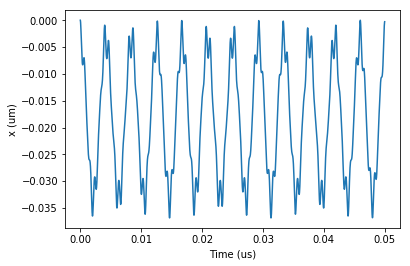

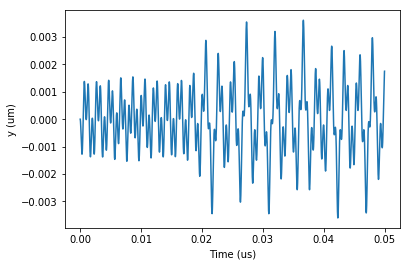

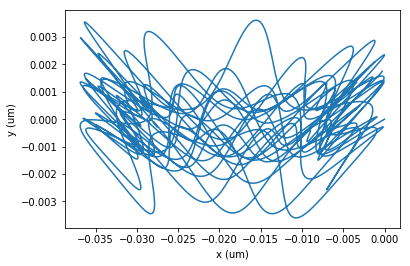

In [11]:
start = time.time()
# simulation configuration
dt = 1.0e-11 #s
t_max = 5.0e-8 # maximum time duration of the simulation

T = 300.0 # kelvin
rou = 0.0 # distance from initial position to the trap center
phi = 0.0 # direction of initial position vector
#v = np.sqrt(2*kB*T/m) #speed
v = 0.0
theta = 0.0 # direction of initial velocity

electron_pos=np.array([rou*np.cos(phi), rou*np.sin(phi)])
electron_vel = np.array([v*np.cos(theta), v*np.sin(theta)])
state = np.array([electron_pos, electron_vel])
t = 0.0 # the time variable
x_traj = []
y_traj = []
t_s = []
trapped = True

# actual simulation
while t < t_max:
    x, y = state[0]
    if not within_boundary(x, y):
        print("out of bound")
        trapped = False
        break
    x_traj.append(x)
    y_traj.append(y)
    t_s.append(t)
    state = rk4(state, t, dt, E_field_sim)
    t += dt
x_traj, y_traj, t_s = np.array(x_traj), np.array(y_traj), np.array(t_s)

print("x_max = ", x_max*1.0e6, "um")
print("y_max = ", y_max*1.0e6, "um")
print("x_min = ", x_min*1.0e6, "um")
print("y_min = ", y_min*1.0e6, "um")
print("spatial resolution x: ", dx*1.0e6, "um")
print("spatial resolution y: ", dy*1.0e6, "um")
print("Time step for simulation: ", dt*1.0e9, "ns")
print("Simulation time duration: ", round(t*1.0e6, 3), "us")
end = time.time()
print("time:", end-start)

plt.figure()
plt.plot(t_s*1.0e6, x_traj*1.0e6)
plt.xlabel("Time (us)")
plt.ylabel("x (um)")

plt.figure()
plt.plot(t_s*1.0e6, y_traj*1.0e6)
plt.xlabel("Time (us)")
plt.ylabel("y (um)")

plt.figure()
plt.plot(x_traj*1.0e6, y_traj*1.0e6)
plt.xlabel("x (um)")
plt.ylabel("y (um)")

## $\rho$ Dependence

In [ ]:
dt = 1.0e-11 #s
t_max = 5.0e-8 # maximum time duration of the simulation

#initial condition
rou_s = np.linspace(0, 300.0e-6, 10)
N_phi = 3
N_theta = 9

# A dictionary, taking temperature as key and the value is a 
# list of success rates correspond to each rou in rou_s
success_rate = dict() 
errors = dict()
for T in [0.01, 4.0, 10.0, 300.0, 500.0, 1000.0]:
    v = np.sqrt(kB*T/m)
    success_rate[T] = [] 
    errors[T] = []
    print("Simulating T = ", T, "kelvin")
    for rou in rou_s:
        result = []
        for phi in np.linspace(0, np.pi/2, N_phi):
            for theta in np.linspace(0, np.pi*2, N_theta):
                if trapped(rou, phi, v, theta, dt, t_max):
                    result.append(1)
                else:
                    result.append(0)
        success_rate[T].append(np.mean(result))
        errors[T].append(np.std(result)/np.sqrt(N_phi*N_theta))
    print("The result for T = ", T, "kelvin:")
    plt.figure()
    plt.plot(rou_s*1.0e6, success_rate[T], 'rx')
    

In [14]:
get_row_index(0, 0)

8004000

In [22]:
df.iloc[8004000]

x      0.000000
y      0.000000
z      0.000000
Ex    15.071916
Ey    -0.504055
Ez     0.000000
Name: 8004000, dtype: float64

In [25]:
df.loc[(np.abs(df["x"]) < 2.0e-6) & (np.abs(df["y"]) < 2.0e-6)]

,x,y,z,Ex,Ey,Ez
7999998,-1.000000e-06,-1.000000e-06,0.0,122.132577,-110.780756,0.0
7999999,-1.000000e-06,0.000000e+00,0.0,125.241758,-1.683659,0.0
8000000,-1.000000e-06,1.000000e-06,0.0,121.008716,109.254408,0.0
8000001,-1.000000e-06,2.000000e-06,0.0,115.819803,215.138278,0.0
8003999,0.000000e+00,-1.000000e-06,0.0,13.571371,-108.554558,0.0
8004000,0.000000e+00,0.000000e+00,0.0,15.071916,-0.504055,0.0
8004001,0.000000e+00,1.000000e-06,0.0,14.741849,107.103053,0.0
8004002,0.000000e+00,2.000000e-06,0.0,14.413151,214.735250,0.0
8008000,1.000000e-06,-1.000000e-06,0.0,-93.051615,-108.677881,0.0
8008001,1.000000e-06,0.000000e+00,0.0,-94.157387,0.718795,0.0


In [31]:
N = 200
T = 0.01
dt = 1.0e-11
FWHM = 50.0e-6
t_max_dependence_cold = dict()
error_t_max_dependence_cold = dict()
for t_max in [5.0e-8, 20.0e-8, 40.0e-8]:
    trap_rate = 0
    result_list = Boltzmann_sim(N, T, dt, t_max, FWHM)
    trap_rate = sum(result_list)/N
    error_trap_rate = np.std(result_list)/np.sqrt(N)
    t_max_dependence_cold[t_max] = trap_rate
    error_t_max_dependence_cold[t_max] = error_trap_rate


1  electron samples already simulated
21  electron samples already simulated
41  electron samples already simulated
61  electron samples already simulated
81  electron samples already simulated
101  electron samples already simulated
121  electron samples already simulated
141  electron samples already simulated
161  electron samples already simulated
181  electron samples already simulated
T:  0.01 Kelvin
N_samples:  200
Time step:  0.01 ns
Max Sim Time:  0.049999999999999996 us
FWHM:  50.0 um
Trapping Rate:  1.0 +/- 0.0
------
1  electron samples already simulated
21  electron samples already simulated
41  electron samples already simulated
61  electron samples already simulated
81  electron samples already simulated
101  electron samples already simulated
121  electron samples already simulated
141  electron samples already simulated
161  electron samples already simulated
181  electron samples already simulated
T:  0.01 Kelvin
N_samples:  200
Time step:  0.01 ns
Max Sim Time:  0.19